# Python: Hyperparametertuning with Optuna

This notebook explains how to use the implmented `tune_ml_models()` method to tune hyperparameters using the [Optuna](https://optuna.org/) package.

In this example, we will focus on the [DoubleMLAPO](https://docs.doubleml.org/stable/api/generated/doubleml.irm.DoubleMLAPO.html#doubleml.irm.DoubleMLAPO) model to estimate average potential outcomes (APOs) in an interactive regression model (see [DoubleMLIRM](https://docs.doubleml.org/stable/guide/models.html#binary-interactive-regression-model-irm)).

The goal is to estimate the average potential outcome

 $$\theta_0 =\mathbb{E}[Y(d)]$$

for a given treatment level $d$ and and discrete valued treatment $D$.

For a more detailed description of the DoubleMLAPO model, see [Average Potential Outcome Model](https://docs.doubleml.org/stable/guide/models.html#average-potential-outcomes-apos) or [Example Gallery](https://docs.doubleml.org/stable/examples/index.html).

In [34]:
import optuna
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor, LGBMClassifier

from doubleml.data import DoubleMLData
from doubleml.irm import DoubleMLAPO
from doubleml.irm.datasets import make_irm_data_discrete_treatments

## Data Generating Process (DGP)

At first, let us generate data according to the [make_irm_data_discrete_treatments](https://docs.doubleml.org/dev/api/datasets.html#dataset-generators) data generating process. The process generates data with a continuous treatment variable and contains the true individual treatment effects (ITEs) with respect to option of not getting treated.

According to the continuous treatment variable, the treatment is discretized into multiple levels, based on quantiles. Using the *oracle* ITEs, enables the comparison to the true APOs and averate treatment effects (ATEs) for the different levels of the treatment variable.

**Remark:** The average potential outcome model does not require an underlying continuous treatment variable. The model will work identically if the treatment variable is discrete by design.

In [31]:
# Parameters
n_obs = 3000
n_levels = 5
linear = True
n_rep = 10

np.random.seed(42)
data_apo = make_irm_data_discrete_treatments(n_obs=n_obs,n_levels=n_levels, linear=linear)

y0 = data_apo['oracle_values']['y0']
cont_d = data_apo['oracle_values']['cont_d']
ite = data_apo['oracle_values']['ite']
d = data_apo['d']
potential_level = data_apo['oracle_values']['potential_level']
level_bounds = data_apo['oracle_values']['level_bounds']

average_ites = np.full(n_levels + 1, np.nan)
apos = np.full(n_levels + 1, np.nan)
mid_points = np.full(n_levels, np.nan)

for i in range(n_levels + 1):
    average_ites[i] = np.mean(ite[d == i]) * (i > 0)
    apos[i] = np.mean(y0) + average_ites[i]

print(f"Average Individual effects in each group:\n{np.round(average_ites,2)}\n")
print(f"Average Potential Outcomes in each group:\n{np.round(apos,2)}\n")
print(f"Levels and their counts:\n{np.unique(d, return_counts=True)}")

Average Individual effects in each group:
[ 0.    1.75  7.03  9.43 10.4  10.49]

Average Potential Outcomes in each group:
[210.04 211.79 217.06 219.47 220.44 220.53]

Levels and their counts:
(array([0., 1., 2., 3., 4., 5.]), array([615, 487, 465, 482, 480, 471]))


As for all [DoubleML](https://docs.doubleml.org/stable/index.html) models, we specify a [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.data.DoubleMLData.html) object to handle the data.

In [ ]:
y = data_apo['y']
x = data_apo['x']
d = data_apo['d']
df_apo = pd.DataFrame(
    np.column_stack((y, d, x)),
    columns=['y', 'd'] + ['x' + str(i) for i in range(data_apo['x'].shape[1])]
)

dml_data = DoubleMLData(df_apo, 'y', 'd')
print(dml_data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['x0', 'x1', 'x2', 'x3', 'x4']
Instrument variable(s): None
No. Observations: 3000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 7 entries, y to x4
dtypes: float64(7)
memory usage: 164.2 KB



## Basic Tuning Example

At first, we will take a look at a very basic tuning example without much customization.

### Define Nuisance Learners

For our example, we will choose [LightGBM](https://lightgbm.readthedocs.io/en/stable/) learners, which are typical non-parametric choice.

In [61]:
ml_g = LGBMRegressor(random_state=314, verbose=-1)
ml_m = LGBMClassifier(random_state=314, verbose=-1)

### Untuned Model

Now let us take a look at the standard workflow, focusing on a single treatment level and using default hyperparameters.

In [62]:
treatment_level = 1.0

In [63]:
dml_obj_untuned = DoubleMLAPO(
    dml_data,
    ml_g,
    ml_m,
    treatment_level=treatment_level,
)

dml_obj_untuned.fit()
dml_obj_untuned.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
d,211.037,3.144354,67.116163,0.0,204.874178,217.199821


### Hyperparametertuning

Now, let us take a look at the basic hyperparametertuning. We will initialize a separate model to compare the results.

In [64]:
dml_obj_tuned = DoubleMLAPO(
    dml_data,
    ml_g,
    ml_m,
    treatment_level=treatment_level,
)

To required input for tuning is a parameter space dictionary for the hyperparameters for each learner that should be tuned.
This dictionary should include a callable for each learner you want to have. 

**Remark**: Even if the initialization only requires the learners `ml_g` and `ml_m`, the models in the `irm` submodule generally, copy the learner for `ml_g` and fit different response surfaces for treatment and control groups. These different learners should be tuned separately and require separate parameter spaces. To see which parameter spaces can be tuned you can take a look at the `params_names` property.

In [57]:
dml_obj_tuned.params_names

['ml_g_d_lvl0', 'ml_g_d_lvl1', 'ml_m']

The parameter spaces should be a callable and suggest the search spaces via a `trial` object.

Generally, the hyperparameter structure should follow the definitions in [Optuna](https://optuna.org/#key_features), but instead of the objective the hyperparameters have to be specified as a callable. The corresponding DoubleML object then assigns a corresponding objective for each learning using the supplied parameter space.

To keep this example fast and simple, we keep the `n_estimators` fix and only tune a small number of other hyperparameters.

In [69]:
# parameter space for the propensity score tuning
def ml_m_params(trial):
    return {
        'n_estimators': 100,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

# parameter space for the outcome regression tuning at treatment level != 1.0
def ml_g_d_lvl0_params(trial):
    return {
        'n_estimators': 100,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

# parameter space for the outcome regression tuning at treatment level == 1.0
def ml_g_d_lvl1_params(trial):
    return {
        'n_estimators': 100,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

param_space = {
    'ml_g_d_lvl0': ml_g_d_lvl0_params,
    'ml_g_d_lvl1': ml_g_d_lvl1_params,
    'ml_m': ml_m_params
}

To tune the hyperparameters the `tune_ml_models()` with the `ml_param_space` argument should be called.
To define the number of trials and other optuna options you can use the `optuna_setttings` argument.

In [71]:
optuna_settings = {
    'n_trials': 20,
    'show_progress_bar': True,
}

dml_obj_tuned.tune_ml_models(
    ml_param_space=param_space,
    optuna_settings=optuna_settings,
)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Per default, the model will set the best hyperparameters automatically (identical hyperparameters for each fold), and you can directly call the `fit()` method afterwards.

In [72]:
dml_obj_tuned.fit()
dml_obj_tuned.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
d,212.419954,0.809782,262.317486,0.0,210.83281,214.007097


### Result Comparison

Let us compare the results for both models.

In [75]:
dml_obj_untuned.evaluate_learners()

{'ml_g_d_lvl0': array([[5.49395703]]),
 'ml_g_d_lvl1': array([[8.74099323]]),
 'ml_m': array([[0.37870167]])}

In [76]:
dml_obj_tuned.evaluate_learners()

{'ml_g_d_lvl0': array([[5.52963968]]),
 'ml_g_d_lvl1': array([[8.70845178]]),
 'ml_m': array([[0.36423921]])}

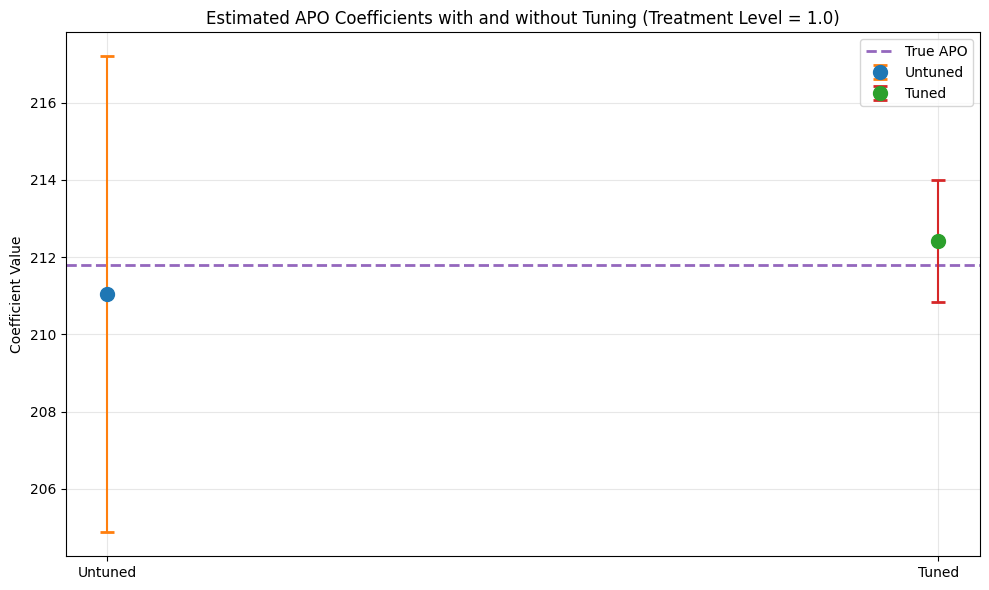


Numerical Comparison:
  Model      theta   ci_lower   ci_upper
Untuned 211.037000 204.874178 217.199821
  Tuned 212.419954 210.832810 214.007097

True APO at treatment level 1.0: 211.7858


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the color palette
palette = sns.color_palette()

# Extract results from both models
theta_untuned = dml_obj_untuned.coef[0]
theta_tuned = dml_obj_tuned.coef[0]
ci_untuned = dml_obj_untuned.confint()
ci_tuned = dml_obj_tuned.confint()

# Create comparison dataframe
comparison_data = {
    'Model': ['Untuned', 'Tuned'],
    'theta': [theta_untuned, theta_tuned],
    'ci_lower': [ci_untuned.iloc[0, 0], ci_tuned.iloc[0, 0]],
    'ci_upper': [ci_untuned.iloc[0, 1], ci_tuned.iloc[0, 1]]
}
df_comparison = pd.DataFrame(comparison_data)

# Plotting
plt.figure(figsize=(10, 6))

# Plot untuned estimate with 95% CI
plt.errorbar(0, df_comparison.loc[0, 'theta'], 
             yerr=[[df_comparison.loc[0, 'theta'] - df_comparison.loc[0, 'ci_lower']], 
                   [df_comparison.loc[0, 'ci_upper'] - df_comparison.loc[0, 'theta']]], 
             fmt='o', capsize=5, capthick=2, ecolor=palette[1], color=palette[0], 
             label='Untuned', markersize=10, zorder=2)

# Plot tuned estimate with 95% CI
plt.errorbar(1, df_comparison.loc[1, 'theta'], 
             yerr=[[df_comparison.loc[1, 'theta'] - df_comparison.loc[1, 'ci_lower']], 
                   [df_comparison.loc[1, 'ci_upper'] - df_comparison.loc[1, 'theta']]], 
             fmt='o', capsize=5, capthick=2, ecolor=palette[3], color=palette[2], 
             label='Tuned', markersize=10, zorder=2)

# Plot true APO as horizontal reference line
plt.axhline(y=apos[int(treatment_level)], color=palette[4], linestyle='--', 
            linewidth=2, label='True APO', zorder=1)

plt.title(f'Estimated APO Coefficients with and without Tuning (Treatment Level = {treatment_level})')
plt.ylabel('Coefficient Value')
plt.xticks([0, 1], ['Untuned', 'Tuned'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print numerical comparison
print("\nNumerical Comparison:")
print(df_comparison.to_string(index=False))
print(f"\nTrue APO at treatment level {treatment_level}: {apos[int(treatment_level)]:.4f}")

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
# Plot Estimate with 95% CI
plt.errorbar(df_apo_ci['treatment_level'], df_apo_ci['theta'], 
             yerr=[df_apo_ci['theta'] - df_apo_ci['ci_lower'], df_apo_ci['ci_upper'] - df_apo_ci['theta']], 
             fmt='o', capsize=5, capthick=2, ecolor=palette[1], color=palette[0], label='Estimate with 95% CI', zorder=2)
# Plot APO as a scatter plot, with zorder set to 2 to be in front
plt.scatter(df_apo_ci['treatment_level'], df_apo_ci['apo'], color=palette[2], label='APO', marker='d', zorder=3)

plt.title('Estimated APO, Theta, and 95% Confidence Interval by Treatment Level')
plt.xlabel('Treatment Level')
plt.ylabel('Value')
plt.xticks(df_apo_ci['treatment_level'])
plt.legend()
plt.grid(True)
plt.show()

## Detailed Hyperparameter Tuning Guide